In [205]:
import pandas as pd
import seaborn as sns
import requests
sns.set(style="darkgrid", rc={'figure.figsize':(12,8)})

## define functions

In [206]:
def url2df(url):
    f = requests.get(url)
    df_raw = pd.read_json(f.text)
    df_raw.scannedDevicesMinTimestamp= pd.to_datetime(df_raw.scannedDevicesMinTimestamp)
    df_raw.scannedDevicesMaxTimestamp= pd.to_datetime(df_raw.scannedDevicesMaxTimestamp)
    df_raw = df_raw.rename(columns={'scannedDevicesMinTimestamp': 'scannedDevicesMinUTC',
                    'scannedDevicesMaxTimestamp': 'scannedDevicesMaxUTC'})
    df_raw = df_raw.sort_values("scannedDevicesMaxUTC") # sorting by last time!
    return df_raw

In [207]:
def scannedDevices2df(scannedDevices):
    df_sd = pd.json_normalize(scannedDevices)
    if df_sd.empty:
#         print('No scans avaliable')
        return df_sd
    df_sd = df_sd.rename(columns={'timestamp': 'timeUTC'})
    df_sd.timeUTC= pd.to_datetime(df_sd.timeUTC)
    df_sd = df_sd.sort_values("timeUTC")
    return df_sd

In [208]:
def allScannedDevicesInTime(df, rel_time, window_size_minutes=0):
# rel_time = pd.to_datetime("2020-03-25 13:00:00")
    sd = pd.DataFrame()
    id_suffix = df.scanningDeviceEddystoneUid[0][-6:]
    time_window = pd.offsets.Minute(window_size_minutes)
    mask = (df.scannedDevicesMinUTC <= rel_time+time_window) & (df.scannedDevicesMaxUTC >= rel_time-time_window)
    if not any(mask):
        print('No date at this time from: ...' + id_suffix)
        return sd
    for row in df[mask].index:
        sd_new = scannedDevices2df(df.scannedDevices[row])
        if sd_new.empty:
            print('No scans avaliable from: ...' + id_suffix)
            continue
        sd = pd.concat([sd, sd_new], ignore_index=True)
    return sd

## access raw data

#### Jonatan's Pocophone

In [209]:
url1 = "https://us-central1-social-protection-46da6.cloudfunctions.net/getDeviceScans?device_id=7BB8BD884D95DBBD613526BE32778B20"
df1 = url2df(url=url1)
df1.tail()

,scannedDevicesMaxUTC,scanningDeviceEddystoneUid,device_seen_set,scannedDevicesMinUTC,scannedDevices
71,2020-03-26 10:24:59.749149200,7BB8BD884D95DBBD613526BE32778B20,"[7BB8BD884D95DBBD613588BD06DA4164, 7BB8BD884D9...",2020-03-26 10:24:15.633697800,"[{'timestamp': 1585218255633697800, 'rssi': -8..."
48,2020-03-26 10:27:13.921507800,7BB8BD884D95DBBD613526BE32778B20,"[7BB8BD884D95DBBD613588BD06DA4164, 7BB8BD884D9...",2020-03-26 10:24:53.168140300,"[{'scannedDeviceRangingData': -15, 'scannedDev..."
129,2020-03-26 10:27:13.922391600,7BB8BD884D95DBBD613526BE32778B20,"[7BB8BD884D95DBBD613588BD06DA4164, 7BB8BD884D9...",2020-03-26 10:24:15.632797700,"[{'scannedDeviceRangingData': -15, 'scannedDev..."
141,2020-03-26 10:27:13.923541500,7BB8BD884D95DBBD613526BE32778B20,"[7BB8BD884D95DBBD613588BD06DA4164, 7BB8BD884D9...",2020-03-26 10:25:58.228284200,"[{'timestamp': 1585218358228284200, 'rssi': -8..."
46,2020-03-26 10:31:43.625695200,7BB8BD884D95DBBD613526BE32778B20,"[7BB8BD884D95DBBD613588BD06DA4164, 7BB8BD884D9...",2020-03-26 10:30:43.143433200,"[{'scannedDeviceRangingData': -15, 'scannedDev..."


#### Dor's OnePlus6

In [210]:
url2 = "https://us-central1-social-protection-46da6.cloudfunctions.net/getDeviceScans?device_id=7BB8BD884D95DBBD613588BD06DA4164" 
df2 = url2df(url=url2)
df2.tail()

,scannedDevicesMaxUTC,scanningDeviceEddystoneUid,device_seen_set,scannedDevicesMinUTC,scannedDevices
12,2020-03-26 13:40:39.839,7BB8BD884D95DBBD613588BD06DA4164,[7BB8BD884D95DBBD613588BD06DA4164],2020-03-26 13:40:39.839,[]
56,2020-03-26 13:45:39.840,7BB8BD884D95DBBD613588BD06DA4164,[7BB8BD884D95DBBD613588BD06DA4164],2020-03-26 13:45:39.840,[]
70,2020-03-26 13:50:39.839,7BB8BD884D95DBBD613588BD06DA4164,[7BB8BD884D95DBBD613588BD06DA4164],2020-03-26 13:50:39.839,[]
27,2020-03-26 13:55:39.839,7BB8BD884D95DBBD613588BD06DA4164,[7BB8BD884D95DBBD613588BD06DA4164],2020-03-26 13:55:39.839,[]
57,2020-03-26 14:00:39.839,7BB8BD884D95DBBD613588BD06DA4164,[7BB8BD884D95DBBD613588BD06DA4164],2020-03-26 14:00:39.839,[]


## find relevant rows in time

No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164
No scans avaliable from: ...DA4164


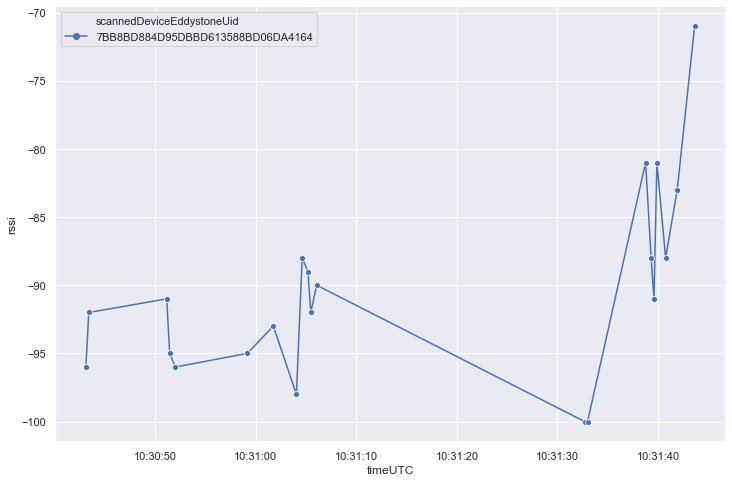

In [216]:
rel_time = pd.to_datetime("2020-03-26 11:00:00")
sd1 = allScannedDevicesInTime(df1, rel_time, 30)
sd2 = allScannedDevicesInTime(df2, rel_time, 30)
sd = pd.concat([sd1, sd2], ignore_index=True)

if not sd.empty:
    sns.lineplot(x="timeUTC", y="rssi",
                 hue="scannedDeviceEddystoneUid",
                 style="scannedDeviceEddystoneUid",
                 data=sd, markers=True)